In [ ]:
!pip install imagehash # Install missing library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 15.5 MB/s eta 0:00:00


--- Step 1: Differential detection pipeline configuration ---
Creating reference image database...
10 reference images loaded successfully.
--- Step 1: Differential detection pipeline configuration ---
Creating reference image database...
10 reference images loaded successfully.

--- Running pipeline on image: 04_mouse_bite_04.jpg ---
Best match found: '04.JPG' (hash distance: 4).
Initial detection completed in 15.28s. 10 raw anomalies found.
3 final anomalies after Non-Max Suppression.
Font 'DejaVuSans.ttf' not found. Using default font (may be small).


/tmp/ipython-input-1100840947.py:355: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_labels) + 1)


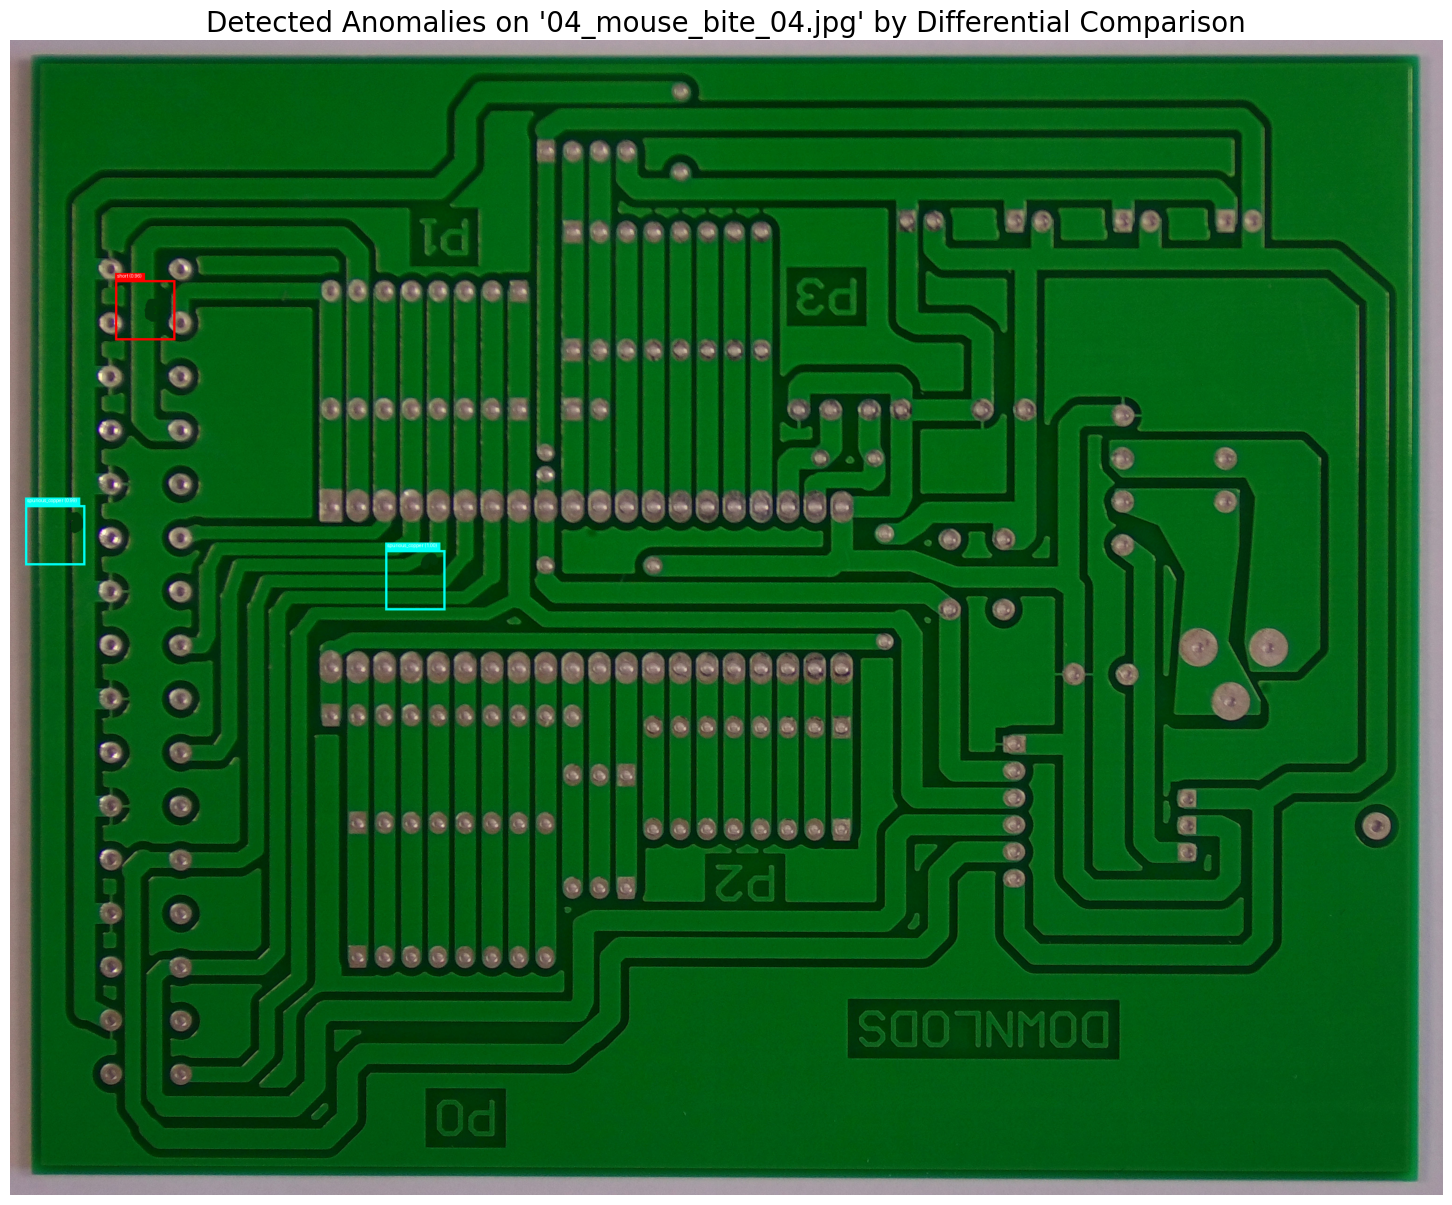

In [ ]:
import os
import time
import numpy as np
import torch
from torchvision import models, transforms
from torchvision.ops import nms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import imagehash
from skimage.metrics import structural_similarity as ssim

print("--- Step 1: Differential detection pipeline configuration ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 1. LOAD CHECKPOINT (MODEL + CLASS NAMES)
# ===================================================================
model_path = "/content/drive/MyDrive/Colab Notebooks/best_resnet50_pcb_defects_50epochs.pth"

checkpoint = torch.load(model_path, map_location=device)
# checkpoint is a dict like: {"model_state_dict": ..., "class_names": ...}

# restore class names from checkpoint (preferred)
class_names = checkpoint.get("class_names", None)
if class_names is None:
    # fallback: manually define if not present
    class_names = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


num_classes = len(class_names)

# recreate architecture exactly as during training
defect_classifier = models.resnet50(weights=None) # Change it accordingly
in_features = defect_classifier.fc.in_features
defect_classifier.fc = torch.nn.Linear(in_features, num_classes)

# load ONLY the model_state_dict from checkpoint
defect_classifier.load_state_dict(checkpoint["model_state_dict"])

defect_classifier.to(device)
defect_classifier.eval()

# ===================================================================
# 2. CONFIG: GOLDEN IMAGES, WINDOW, NORMALIZATION
# ===================================================================
golden_images_dir = "/content/drive/MyDrive/PCB_DATASET/PCB_USED/"
if not os.path.exists(golden_images_dir):
    raise FileNotFoundError(f"Reference images directory '{golden_images_dir}' not found.")

WINDOW_SIZE = 128
STRIDE = WINDOW_SIZE // 4
SIMILARITY_THRESHOLD = 0.95
CLASSIFIER_CONFIDENCE_THRESHOLD = 0.80

# same normalization as training
inference_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===================================================================
# 3. GOLDEN IMAGE DATABASE
# ===================================================================
def create_golden_image_database(golden_dir):
    db = []
    print("Creating reference image database...")
    filenames = os.listdir(golden_dir)
    for fname in filenames:
        path = os.path.join(golden_dir, fname)
        try:
            img = Image.open(path).convert('RGB')
            hash_val = imagehash.phash(img)
            db.append({'filename': fname, 'image': img, 'hash': hash_val})
        except Exception as e:
            print(f"Warning: Could not load '{path}'. Error: {e}")
    return db

golden_db = create_golden_image_database(golden_images_dir)
print(f"{len(golden_db)} reference images loaded successfully.")

# ===================================================================
# 4. DETECTION FUNCTIONS
# ===================================================================
def find_best_match(input_image, golden_database):
    if not golden_database:
        return None
    input_hash = imagehash.phash(input_image)
    best_match = min(golden_database, key=lambda x: input_hash - x['hash'])
    min_dist = input_hash - best_match['hash']
    print(f"Best match found: '{best_match['filename']}' (hash distance: {min_dist}).")
    if min_dist > 10:
        print("Warning: High hash distance, match may be incorrect.")
    return best_match['image']


def detect_anomalies_by_comparison(input_image, golden_image, classifier):
    if input_image.size != golden_image.size:
        raise ValueError("Input image and reference image must have the same dimensions!")

    detections = []
    start_time = time.time()

    img_width, img_height = input_image.size
    for y in range(0, img_height - WINDOW_SIZE + 1, STRIDE):
        for x in range(0, img_width - WINDOW_SIZE + 1, STRIDE):
            window_input = input_image.crop((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE))
            window_golden = golden_image.crop((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE))

            window_input_gray = np.array(window_input.convert('L'))
            window_golden_gray = np.array(window_golden.convert('L'))

            ssim_score, _ = ssim(window_golden_gray, window_input_gray, full=True)

            if ssim_score < SIMILARITY_THRESHOLD:
                patch_tensor = inference_transform(window_input).unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = classifier(patch_tensor)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    confidence, predicted_idx = torch.max(probabilities, 1)

                if confidence.item() > CLASSIFIER_CONFIDENCE_THRESHOLD:
                    detections.append({
                        'box': [x, y, x + WINDOW_SIZE, y + WINDOW_SIZE],
                        'label': class_names[predicted_idx.item()],
                        'confidence': confidence.item()
                    })

    print(f"Initial detection completed in {time.time() - start_time:.2f}s. {len(detections)} raw anomalies found.")

    if not detections:
        return []

    boxes = torch.tensor([d['box'] for d in detections], dtype=torch.float32)
    scores = torch.tensor([d['confidence'] for d in detections], dtype=torch.float32)
    keep_indices = nms(boxes, scores, iou_threshold=0.2)

    final_detections = [detections[i] for i in keep_indices]
    print(f"{len(final_detections)} final anomalies after Non-Max Suppression.")
    return final_detections


def draw_detections_on_image(image, detections):
    img_with_boxes = image.copy()
    draw = ImageDraw.Draw(img_with_boxes)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 32)
    except IOError:
        print("Font 'DejaVuSans.ttf' not found. Using default font (may be small).")
        font = ImageFont.load_default()

    unique_labels = list(set([d['label'] for d in detections]))
    colors = plt.cm.get_cmap('hsv', len(unique_labels) + 1)
    color_map = {
        label: tuple((np.array(colors(i)[:3]) * 255).astype(int))
        for i, label in enumerate(unique_labels)
    }

    for det in detections:
        box = det['box']
        label = det['label']
        confidence = det['confidence']

        color = color_map.get(label, (255, 50, 50))
        draw.rectangle(box, outline=color, width=5)

        text = f"{label} ({confidence:.2f})"

        try:
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
        except AttributeError:
            text_width, text_height = draw.textsize(text, font=font)

        background_box = [
            box[0],
            box[1] - text_height - 5,
            box[0] + text_width + 10,
            box[1]
        ]
        draw.rectangle(background_box, fill=color)
        draw.text((box[0] + 5, box[1] - text_height - 5),
                  text, fill="white", font=font)

    return img_with_boxes

# ===================================================================
# 5. RUN PIPELINE ON EXAMPLE IMAGE
# ===================================================================
import os
import time
import numpy as np
import torch
from torchvision import models, transforms
from torchvision.ops import nms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import imagehash
from skimage.metrics import structural_similarity as ssim

print("--- Step 1: Differential detection pipeline configuration ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 1. LOAD CHECKPOINT (MODEL + CLASS NAMES)
# ===================================================================
model_path = "/content/drive/MyDrive/Colab Notebooks/best_resnet50_pcb_defects_50epochs.pth"

checkpoint = torch.load(model_path, map_location=device)
# checkpoint is a dict like: {"model_state_dict": ..., "class_names": ...}

# restore class names from checkpoint (preferred)
class_names = checkpoint.get("class_names", None)
if class_names is None:
    # fallback: manually define if not present
    class_names = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']

if 'normal' in class_names:
    class_names.remove('normal')

num_classes = len(class_names)

# recreate architecture exactly as during training
defect_classifier = models.resnet50(weights=None)
in_features = defect_classifier.fc.in_features
defect_classifier.fc = torch.nn.Linear(in_features, num_classes)

# load ONLY the model_state_dict from checkpoint
defect_classifier.load_state_dict(checkpoint["model_state_dict"])

defect_classifier.to(device)
defect_classifier.eval()

# ===================================================================
# 2. CONFIG: GOLDEN IMAGES, WINDOW, NORMALIZATION
# ===================================================================
golden_images_dir = "/content/drive/MyDrive/PCB_DATASET/PCB_USED/"
if not os.path.exists(golden_images_dir):
    raise FileNotFoundError(f"Reference images directory '{golden_images_dir}' not found.")

WINDOW_SIZE = 128
STRIDE = WINDOW_SIZE // 4
SIMILARITY_THRESHOLD = 0.95
CLASSIFIER_CONFIDENCE_THRESHOLD = 0.80

# same normalization as training
inference_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===================================================================
# 3. GOLDEN IMAGE DATABASE
# ===================================================================
def create_golden_image_database(golden_dir):
    db = []
    print("Creating reference image database...")
    filenames = os.listdir(golden_dir)
    for fname in filenames:
        path = os.path.join(golden_dir, fname)
        try:
            img = Image.open(path).convert('RGB')
            hash_val = imagehash.phash(img)
            db.append({'filename': fname, 'image': img, 'hash': hash_val})
        except Exception as e:
            print(f"Warning: Could not load '{path}'. Error: {e}")
    return db

golden_db = create_golden_image_database(golden_images_dir)
print(f"{len(golden_db)} reference images loaded successfully.")

# ===================================================================
# 4. DETECTION FUNCTIONS
# ===================================================================
def find_best_match(input_image, golden_database):
    if not golden_database:
        return None
    input_hash = imagehash.phash(input_image)
    best_match = min(golden_database, key=lambda x: input_hash - x['hash'])
    min_dist = input_hash - best_match['hash']
    print(f"Best match found: '{best_match['filename']}' (hash distance: {min_dist}).")
    if min_dist > 10:
        print("Warning: High hash distance, match may be incorrect.")
    return best_match['image']


def detect_anomalies_by_comparison(input_image, golden_image, classifier):
    if input_image.size != golden_image.size:
        raise ValueError("Input image and reference image must have the same dimensions!")

    detections = []
    start_time = time.time()

    img_width, img_height = input_image.size
    for y in range(0, img_height - WINDOW_SIZE + 1, STRIDE):
        for x in range(0, img_width - WINDOW_SIZE + 1, STRIDE):
            window_input = input_image.crop((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE))
            window_golden = golden_image.crop((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE))

            window_input_gray = np.array(window_input.convert('L'))
            window_golden_gray = np.array(window_golden.convert('L'))

            ssim_score, _ = ssim(window_golden_gray, window_input_gray, full=True)

            if ssim_score < SIMILARITY_THRESHOLD:
                patch_tensor = inference_transform(window_input).unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = classifier(patch_tensor)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    confidence, predicted_idx = torch.max(probabilities, 1)

                if confidence.item() > CLASSIFIER_CONFIDENCE_THRESHOLD:
                    detections.append({
                        'box': [x, y, x + WINDOW_SIZE, y + WINDOW_SIZE],
                        'label': class_names[predicted_idx.item()],
                        'confidence': confidence.item()
                    })

    print(f"Initial detection completed in {time.time() - start_time:.2f}s. {len(detections)} raw anomalies found.")

    if not detections:
        return []

    boxes = torch.tensor([d['box'] for d in detections], dtype=torch.float32)
    scores = torch.tensor([d['confidence'] for d in detections], dtype=torch.float32)
    keep_indices = nms(boxes, scores, iou_threshold=0.2)

    final_detections = [detections[i] for i in keep_indices]
    print(f"{len(final_detections)} final anomalies after Non-Max Suppression.")
    return final_detections


def draw_detections_on_image(image, detections):
    img_with_boxes = image.copy()
    draw = ImageDraw.Draw(img_with_boxes)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 32)
    except IOError:
        print("Font 'DejaVuSans.ttf' not found. Using default font (may be small).")
        font = ImageFont.load_default()

    unique_labels = list(set([d['label'] for d in detections]))
    colors = plt.cm.get_cmap('hsv', len(unique_labels) + 1)
    color_map = {
        label: tuple((np.array(colors(i)[:3]) * 255).astype(int))
        for i, label in enumerate(unique_labels)
    }

    for det in detections:
        box = det['box']
        label = det['label']
        confidence = det['confidence']

        color = color_map.get(label, (255, 50, 50))
        draw.rectangle(box, outline=color, width=5)

        text = f"{label} ({confidence:.2f})"

        try:
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
        except AttributeError:
            text_width, text_height = draw.textsize(text, font=font)

        background_box = [
            box[0],
            box[1] - text_height - 5,
            box[0] + text_width + 10,
            box[1]
        ]
        draw.rectangle(background_box, fill=color)
        draw.text((box[0] + 5, box[1] - text_height - 5),
                  text, fill="white", font=font)

    return img_with_boxes

# ===================================================================
# 5. RUN PIPELINE ON EXAMPLE IMAGE (STANDALONE)
# ===================================================================
test_image_path = "/content/drive/MyDrive/PCB_DATASET/images/Mouse_bite/04_mouse_bite_04.jpg"
test_image_name = os.path.basename(test_image_path)

print(f"\n--- Running pipeline on image: {test_image_name} ---")

try:
    input_image = Image.open(test_image_path).convert('RGB')

    golden_image_ref = find_best_match(input_image, golden_db)

    if golden_image_ref:
        anomalies = detect_anomalies_by_comparison(
            input_image,
            golden_image_ref,
            defect_classifier
        )

        result_image = draw_detections_on_image(input_image, anomalies)

        plt.figure(figsize=(20, 15))
        plt.imshow(result_image)
        plt.title(
            f"Detected Anomalies on '{test_image_name}' by Differential Comparison",
            fontsize=20
        )
        plt.axis('off')
        plt.show()
    else:
        print("No matching golden image found.")

except FileNotFoundError:
    print(f"ERROR: Test file '{test_image_path}' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib


# ==============================
# CONFIG: PATHS
# ==============================
all_images_root = "/content/drive/MyDrive/PCB_DATASET/images"

base_output_dir = "/content/drive/MyDrive/PCB_DATASET/Inference_Results"
os.makedirs(base_output_dir, exist_ok=True)

# One folder per defect directly under Inference_Results
for cls in class_names:
    cls_dir = os.path.join(base_output_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)

# ==============================
# FIXED COLOR MAP PER DEFECT
# ==============================
cmap = matplotlib.colormaps.get_cmap('tab10')

# Deterministic mapping: each defect class -> fixed RGB color
class_color_map = {}
for idx, label in enumerate(class_names):
    color = tuple((np.array(cmap(idx / max(1, len(class_names)))[:3]) * 255).astype(int))
    class_color_map[label] = color


def draw_detections_full_image(image, detections):
    """
    Draws bounding boxes and labels on a copy of the full image.
    Each defect class uses a fixed, unique color from class_color_map.
    """
    img_with_boxes = image.copy()
    draw = ImageDraw.Draw(img_with_boxes)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 32)
    except IOError:
        print("Font 'DejaVuSans.ttf' not found. Using default font (may be small).")
        font = ImageFont.load_default()

    for det in detections:
        box = det['box']              # [x1, y1, x2, y2]
        label = det['label']          # must match class_names entry
        confidence = det['confidence']

        color = class_color_map.get(label, (255, 50, 50))

        # Draw bounding box
        draw.rectangle(box, outline=color, width=5)

        text = f"{label} ({confidence:.2f})"

        # Text size
        try:
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
        except AttributeError:
            text_width, text_height = draw.textsize(text, font=font)

        # Text background rectangle
        background_box = [
            box[0],
            box[1] - text_height - 5,
            box[0] + text_width + 10,
            box[1]
        ]
        draw.rectangle(background_box, fill=color)
        draw.text((box[0] + 5, box[1] - text_height - 5),
                  text, fill="white", font=font)

    return img_with_boxes


def save_full_image_per_defect(input_image, detections, image_path):
    """
    For one image:
    - Draw one annotated full image with all detections.
    - Save a copy of this image into each defect-specific folder
      under Inference_Results corresponding to defects present.

    Example structure:
    /content/drive/MyDrive/Inference_Results/open_circuit/xxx_with_boxes.jpg
    /content/drive/MyDrive/Inference_Results/spurious_copper/xxx_with_boxes.jpg
    """
    if not detections:
        return

    # Build base name from path relative to all_images_root
    rel_path = os.path.relpath(image_path, all_images_root)
    rel_path_no_sep = rel_path.replace(os.sep, "_")
    base_name, ext = os.path.splitext(rel_path_no_sep)

    # Draw annotated image once
    annotated = draw_detections_full_image(input_image, detections)

    # All defect labels present in this image
    present_labels = sorted(set(d['label'] for d in detections))

    for label in present_labels:
        defect_folder = os.path.join(base_output_dir, label)
        os.makedirs(defect_folder, exist_ok=True)

        save_name = f"{base_name}_with_boxes.jpg"
        save_path = os.path.join(defect_folder, save_name)
        annotated.save(save_path)
        print(f"Saved annotated image for defect '{label}': {save_path}")


def is_image_file(fname):
    fname_lower = fname.lower()
    return fname_lower.endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))


# ==========================================================
# LOOP OVER ALL IMAGES AND SAVE FULL RESULTS PER DEFECT
# ==========================================================
print(f"--- Running pipeline and saving FULL images per defect for all images in: {all_images_root} ---")

total_images = 0
processed_images = 0
skipped_images = 0

for root, dirs, files in os.walk(all_images_root):
    for fname in files:
        if not is_image_file(fname):
            continue

        total_images += 1
        img_path = os.path.join(root, fname)
        print(f"\nProcessing: {img_path}")

        try:
            input_image = Image.open(img_path).convert('RGB')
            golden_image_ref = find_best_match(input_image, golden_db)

            if golden_image_ref:
                anomalies = detect_anomalies_by_comparison(
                    input_image,
                    golden_image_ref,
                    defect_classifier
                )

                # Important: detect_anomalies_by_comparison must set
                # 'label': class_names[predicted_idx.item()]
                save_full_image_per_defect(input_image, anomalies, img_path)
                processed_images += 1
            else:
                print("No matching golden image found. Skipping.")
                skipped_images += 1

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            skipped_images += 1

print("\n=== SUMMARY ===")
print(f"Total image files found: {total_images}")
print(f"Successfully processed: {processed_images}")
print(f"Skipped (errors or no golden match): {skipped_images}")
print(f"Per-defect annotated images saved under: {base_output_dir}")


--- Running pipeline and saving FULL images per defect for all images in: /content/drive/MyDrive/PCB_DATASET/images ---

Processing: /content/drive/MyDrive/PCB_DATASET/images/Open_circuit/10_open_circuit_01.jpg
Best match found: '10.JPG' (hash distance: 0).
Initial detection completed in 11.33s. 24 raw anomalies found.
5 final anomalies after Non-Max Suppression.
Font 'DejaVuSans.ttf' not found. Using default font (may be small).
Saved annotated image for defect 'short': /content/drive/MyDrive/PCB_DATASET/Inference_Results/short/Open_circuit_10_open_circuit_01_with_boxes.jpg
Saved annotated image for defect 'spurious_copper': /content/drive/MyDrive/PCB_DATASET/Inference_Results/spurious_copper/Open_circuit_10_open_circuit_01_with_boxes.jpg

Processing: /content/drive/MyDrive/PCB_DATASET/images/Open_circuit/08_open_circuit_03.jpg
Best match found: '08.JPG' (hash distance: 0).
Initial detection completed in 10.59s. 6 raw anomalies found.
2 final anomalies after Non-Max Suppression.
Font 